In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *

### Create directory and download images.


In [2]:
path = Path('Mithai')

def make_folders(folder, path):
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)
    
make_folders('gulabjamun', path)
make_folders('jalebi', path)
make_folders('rasgulla', path)

In [3]:
download_images(path/'urls_gulabjamun.csv', path/'gulabjamun', max_pics=200)
download_images(path/'urls_jalebi.csv', path/'jalebi', max_pics=200)
download_images(path/'urls_rasgulla.csv', path/'rasgulla', max_pics=200)

Then we remove any images that can't be opened:

In [4]:
classes = ['gulabjamun','jalebi','rasgulla']
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

## View Data

In [5]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [6]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['gulabjamun', 'jalebi', 'rasgulla'], 3, 359, 89)

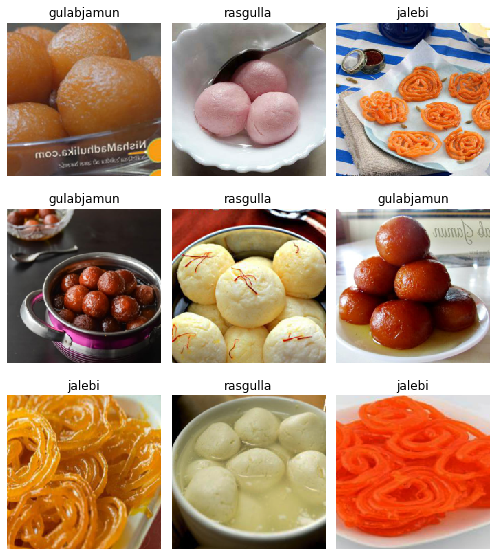

In [7]:
data.show_batch(rows=3, figsize=(7,8))

## Train Data

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [9]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.237337,0.341942,0.123596,00:05
1,0.709049,0.293227,0.067416,00:03
2,0.527594,0.324666,0.101124,00:03
3,0.395875,0.339165,0.112360,00:03


In [10]:
learn.save('stage-1')

In [11]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.058502,0.344068,0.101124,00:03
1,0.058198,0.353666,0.078652,00:03


In [12]:
learn.save('stage-2')

## Interpretation

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

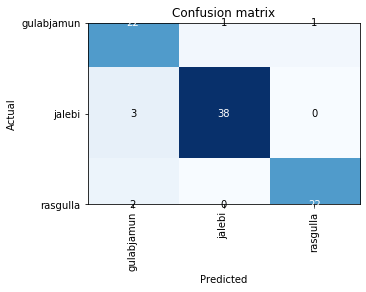

In [18]:
#plt.figure(figsize=(6,6))
interp.plot_confusion_matrix(figsize=(5,5))

In [19]:
losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

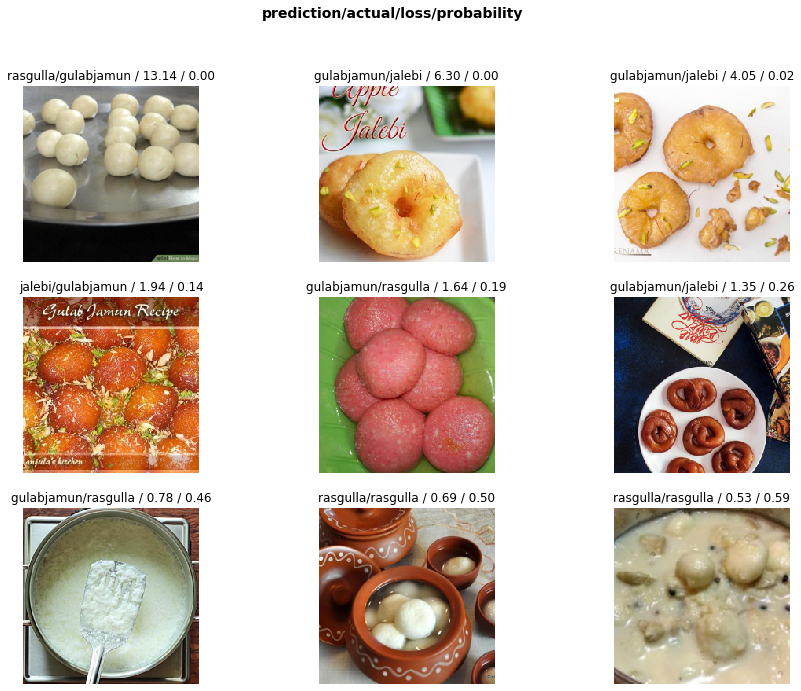

In [20]:
interp.plot_top_losses(9, figsize=(15,11))

## Cleaning training data

In [21]:
from fastai.widgets import *

In [22]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [23]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (448 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
rasgulla,rasgulla,rasgulla,rasgulla,rasgulla
Path: Mithai;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: Mithai;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding

In [24]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [25]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

We create a databunch from our csv.  

In [31]:
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

learn = cnn_learner(data, models.resnet34, metrics=error_rate)

learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.595319,0.431027,0.176471,00:03
1,0.920557,0.198801,0.047059,00:03
2,0.603102,0.192161,0.035294,00:03
3,0.441078,0.197265,0.047059,00:03
4,0.348224,0.205266,0.047059,00:03


In [32]:
learn.save('clean-stage-1')

In [33]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.040656,0.229359,0.047059,00:03
1,0.047398,0.232125,0.047059,00:03


This additional epochs clearly caused overfitting so we'll stick to clean-stage-1 model.

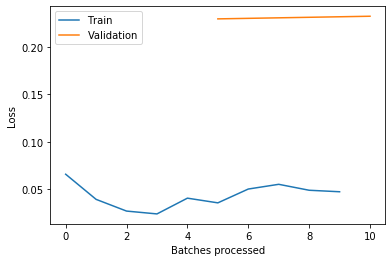

In [34]:
learn.recorder.plot_losses()